In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import sys
import pickle
from matplotlib.ticker import NullFormatter
import matplotlib.path as mpath
import matplotlib.patches as patches


path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

import neurolib_dev_optControl.neurolib.dashboard.data as data
from neurolib_dev_optControl.neurolib.models.aln import ALNModel
import neurolib_dev_optControl.neurolib.dashboard.layout as layout
import neurolib_dev_optControl.neurolib.dashboard.functions as functions
import neurolib_dev_optControl.neurolib.utils.func_optimize as fo

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

rgb_cm = cmap.colors

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

readpath = '.' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
i = 10
dt = 0.01
aln.params.dt = dt

aln.params.ext_exc_current = ext_exc[i] * 5. + 0.1
aln.params.ext_inh_current = ext_inh[i] * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = 5.)
aln.run(control=control0)

def getinitvars():
    init_state_vars = np.zeros(( len(aln.state_vars) ))
    for j in range(len(aln.state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[aln.state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[aln.state_vars[j]][0,-1]

    initVars = init_state_vars
    return initVars


initVars0 = getinitvars()

In [43]:
params_0 = []
params_1 = []

state_0 = []
state_1 = []

mu_i = 0.45

aln = ALNModel()
data.set_parameters(aln)
aln.params.de = 0.
aln.params.di = 0.
maxcounter = 1e4
duration = 1. * 1e0
aln.params.duration = duration
dt = 1. * 1e-7
aln.params.dt = dt
c_amp = 5. * 1e4
control_ = aln.getZeroControl()
control_[0,3,0:np.around(duration*0.8/dt, 1).astype(int)] = 

control1_ = aln.getZeroControl()
control1_[0,3,:] = c_amp
#initVars1 = initVars0.copy()

while mu_i <= 0.45:
    print(mu_i)
    mu_e = 0.436
    
    if mu_i > 0.35:
        mu_e = 0.447
        
    s = 0.0001
    
    counter = 0
    
    while True:
        
        print(mu_e, counter)
        
        aln.params.ext_exc_current = mu_e * 5.
        aln.params.ext_inh_current = mu_i * 5.
    
        setinit(initVars1, aln)
        state = fo.updateFullState(aln, control_, aln.state_vars)
        
        if np.amax(aln.rates_exc[0,:]) > 50.:
            print("MAYBE PROBLEM")
            #plt.plot(aln.t, aln.rates_exc[0,:])
            #plt.show()
            break

        if aln.rates_exc[0,-1] > 5.:
            #params_1.append( [mu_e, mu_i] )
            #state_1.append(state)
            #params_0.append( [mu_e - s, mu_i] )
            
            #plt.plot(aln.t, aln.rates_exc[0,:])
            #plt.show()
            
            if counter <= maxcounter:
                state = fo.updateFullState(aln, control1_, aln.state_vars)
                print('last rates ' , aln.rates_exc[0,-2] - aln.rates_exc[0,-1])
                #plt.plot(aln.t, aln.rates_exc[0,:])
                #plt.show()
                initVars1 = getinitvars()
                counter += 1
                continue
            else:
                print("max iterations reached")
                break
            
        elif aln.rates_exc[0,-1] < 5.:
            print("successful state switch, ", counter, mu_e)
            
            mu_e += s
            counter = 0
            initVars1 = initVars0.copy()
            continue
            
    
    mu_i += 0.1
        
params0 = np.zeros (( len(params_0), 2 ))
params1 = np.zeros (( len(params_0), 2 ))

for k in range(len(params_0)):
    params0[k,0] = params_0[k][0]
    params0[k,1] = params_0[k][1]
    params1[k,0] = params_1[k][0]
    params1[k,1] = params_1[k][1]
    
print(params0)
print(params1)

0.45
0.447 0
last rates  17.396703827313548
0.447 1
last rates  17.396703827313548
0.447 2
last rates  17.396703827313548
0.447 3


KeyboardInterrupt: 

mui  0.45
0.45


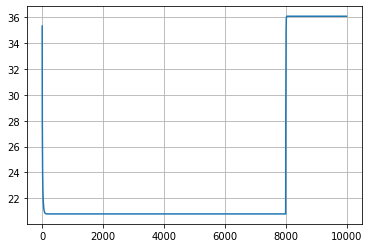

rates_exc

 20.787904948194327658939073444344103336334228515625000000 
 20.787900694702120318879678961820900440216064453125000000 
 20.787904948194327658939073444344103336334228515625000000 
 20.787900694702120318879678961820900440216064453125000000
rates_inh

 81.511758867130339467621524818241596221923828125000000000 
 81.511758867349712431860098149627447128295898437500000000 
 81.511758867130339467621524818241596221923828125000000000 
 81.511758867349712431860098149627447128295898437500000000
mufe

 0.904442776734537101646083101513795554637908935546875000 
 0.904442886446388594201550858997507020831108093261718750 
 0.904442776734537101646083101513795554637908935546875000 
 0.904442886446388594201550858997507020831108093261718750
mufi

 2.736002054430183072497584362281486392021179199218750000 
 2.736002054430085372871417348505929112434387207031250000 
 2.736002054430183072497584362281486392021179199218750000 
 2.736002054430085372871417348505929112434387207031250000
IA

 0.00000000000

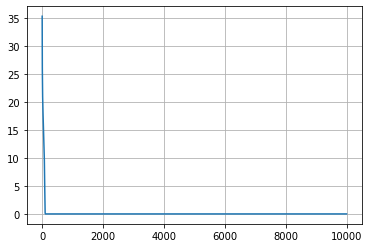

[[0.44 0.45]]
[[0.45 0.45]]


In [5]:
params_0 = []
params_1 = []

state_0 = []
state_1 = []

mu_i = 0.45

aln = ALNModel()
data.set_parameters(aln)
duration = 10000.
aln.params.duration = duration
dt = 1. * 1e-3
aln.params.dt = dt
c_amp = 1 * 1e8
f_control = np.linspace(0.,1.,int(duration/dt))
control_ = aln.getZeroControl()
index = np.around(duration*0.8/dt, 1).astype(int)
control_[0,3,0:index] = f_control[0:index] * c_amp
#control_[0,3,:] = c_amp

while mu_i <= 0.45:
    print('mui ' , mu_i)
    mu_e = 0.43
    s = 0.01
    
    while True:
        
        #print(mu_e)
        
        aln.params.ext_exc_current = mu_e * 5.
        aln.params.ext_inh_current = mu_i * 5.
    
        setinit(initVars0, aln)
        state = fo.updateFullState(aln, control_, aln.state_vars)
        #plt.plot(aln.t, aln.rates_exc[0,:])
        #plt.show()
        
        #for sv in aln.state_vars:
        #    print(sv)
        #    plt.plot(aln.t, aln.state[sv][0,:])
        #    plt.show()
        
        if aln.rates_exc[0,-1] > 5.:
            params_1.append( [mu_e, mu_i] )
            state_1.append(state)
            params_0.append( [mu_e - s, mu_i] )
            
            print(mu_e)
            plt.plot(aln.t, aln.rates_exc[0,:])
            plt.show()
            
            for sv in aln.state_vars:
                print(sv)
                print("\n",
                      "{:.54f}".format(aln.state[sv][0,index-3]), "\n",
                      "{:.54f}".format(aln.state[sv][0,index-2]), "\n",
                      "{:.54f}".format(aln.state[sv][0,index-1]), "\n",
                      "{:.54f}".format(aln.state[sv][0,index]))
            
            aln.params.ext_exc_current = ( mu_e - s ) * 5.
            setinit(initVars0, aln)
            state = fo.updateFullState(aln, control_, aln.state_vars)
            state_0.append(state)
            
            plt.plot(aln.t, aln.rates_exc[0,:])
            plt.show()
            
            break
                        
        mu_e += s    
    mu_i += 0.1
        
params0 = np.zeros (( len(params_0), 2 ))
params1 = np.zeros (( len(params_0), 2 ))

for k in range(len(params_0)):
    params0[k,0] = params_0[k][0]
    params0[k,1] = params_0[k][1]
    params1[k,0] = params_1[k][0]
    params1[k,1] = params_1[k][1]
    
print(params0)
print(params1)

In [5]:
params_0 = []
params_1 = []

state_0 = []
state_1 = []

mu_i = 0.35

aln = ALNModel()
data.set_parameters(aln)
aln.params.duration = 2000.
dt = 0.1
aln.params.dt = dt
control_ = aln.getZeroControl()
control_[0,0,int(50/dt):int(1000/dt)] = -2.
control_[0,1,int(50/dt):int(1000/dt)] = 2.

while mu_i <= 0.7:
    print(mu_i)
    mu_e = 0.43
    s = 0.001
    
    while True:
        
        #print(mu_e)
        
        aln.params.ext_exc_current = mu_e * 5.
        aln.params.ext_inh_current = mu_i * 5.
    
        setinit(initVars, aln)
        state = fo.updateFullState(aln, control_, aln.state_vars)

        if aln.rates_exc[0,-1] > 5.:
            params_1.append( [mu_e, mu_i] )
            state_1.append(state)
            params_0.append( [mu_e - s, mu_i] )
            
            print(mu_e)
            plt.plot(aln.t, aln.rates_exc[0,:])
            plt.show()
            
            aln.params.ext_exc_current = ( mu_e - s ) * 5.
            setinit(initVars, aln)
            state = fo.updateFullState(aln, control_, aln.state_vars)
            state_0.append(state)
            
            print(mu_e - s)
            plt.plot(aln.t, aln.rates_exc[0,:])
            plt.show()
            
            break
            
        mu_e += s    
    mu_i += 0.1
            
bound0 = np.zeros (( len(params_0), 2 ))
bound1 = np.zeros (( len(params_0), 2 ))

for k in range(len(params_0)):
    bound0[k,0] = params_0[k][0]
    bound0[k,1] = params_0[k][1]
    bound1[k,0] = params_1[k][0]
    bound1[k,1] = params_1[k][1]
    
print(bound0)
print(bound1)

"""
[[0.436 0.35 ]
 [0.515 0.45 ]
 [0.564 0.55 ]
 [0.591 0.65 ]]
[[0.437 0.35 ]
 [0.516 0.45 ]
 [0.565 0.55 ]
 [0.592 0.65 ]]
"""

0.35


NameError: name 'initVars' is not defined

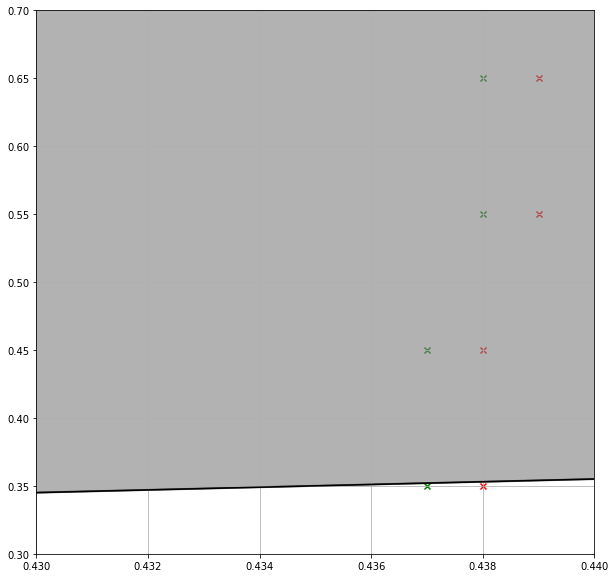

In [38]:
"""
dt=0.002
a = 200
[[0.4468 0.45  ]]
[[0.4469 0.45  ]]

dt=0.002
a = 200
[[0.4469 0.45  ]]
[[0.447 0.45 ]]

dt=0.002
a = 600
[[0.4469 0.45  ]]
[[0.447 0.45 ]]
"""


with open('boundary_bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_bi_exc = load_array[0]
boundary_bi_inh = load_array[1]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_ylim(0.3, .7)
ax.set_xlim(0.43, .44)
#ax.set_xticks(np.arange(0.1, 0.8, 0.1))

vertices = np.zeros(( len(boundary_bi_exc), 2 ))
for i in range(vertices.shape[0]):
    vertices[i,0] = boundary_bi_exc[i]
    vertices[i,1] = boundary_bi_inh[i]
path = mpath.Path(vertices)

patch = patches.PathPatch(path, facecolor='grey', alpha=0.6, lw=2)
ax.add_patch(patch)

x, y = zip(*path.vertices)
line, = ax.plot(x, y, markersize=0, color='black')

ax.scatter( params0[:,0], params0[:,1], color = 'green', marker='x' )
ax.scatter( params1[:,0], params1[:,1], color = 'red', marker='x' )